### CS516 Medical Imaging
### Final Project Part 2
#### Luyun Nie 002268087
#### Junjia Lin 002268506

In [1]:
# import some essencial packages
from google.colab import drive
import gc
gc.collect()
drive.mount('/content/drive') 
import os
import numpy as np
import nibabel as nib 
import matplotlib.pyplot as plt 
from keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam
import tensorflow as tf
%env SM_FRAMEWORK=tf.keras
!pip install segmentation_models
import segmentation_models as sm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [2]:
# scan all files from the root
go = os.listdir('/content/drive/My Drive/final example/')
go.sort(key = str.lower)
trainfile = go[0:15] # set the train files
testfile = go[15:20] # set the test files

In [3]:
trainfile = go[0:15]
testfile = go[15:20]
print(trainfile,testfile)

['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15'] ['sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20']


Note: We utilize the groundseg data provided from Dr.Butler to confirm we would not mess up by image data made from part 1.

In [4]:
# set the model
BACKBONE = 'resnet34'
#preprocess_input = sm.get_preprocessing(BACKBONE)

model = sm.Unet(BACKBONE, input_shape=(None,None,3),encoder_weights='imagenet')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [5]:
# set a loop to run fitting model to train itself
val_iou_scorelist = [[]]
for train in trainfile:
  groundseg = nib.load(os.path.join('/content/drive/My Drive/final example/',train)+'/tof_arteries.nii.gz').get_data()
  t1 = nib.load(os.path.join('/content/drive/My Drive/final example/',train)+'/t1_in_tof.nii.gz').get_data()
  groundseg = np.swapaxes(groundseg,0,2)
  t1 = np.swapaxes(t1,0,2)
  groundseg = np.expand_dims(groundseg,axis=3)
  t1 = np.expand_dims(t1,axis=3)
  t1 = np.tile(t1,[1,1,1,3])
  x_train = t1[0::2,:,:,:]
  y_train = groundseg[0::2,:,:,:].astype(np.float32)
  x_val = t1[1::2,:,:,:]
  y_val = groundseg[1::2,:,:,:].astype(np.float32)
  model.fit(x=x_train,y=y_train,batch_size=16,epochs=100,validation_data=(x_val, y_val))
  # add the history result to a list
  val_iou_scorelist.append(model.history.history['val_iou_score'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


Epoch 1/100
6/6 [==============================] - 15s 928ms/step - loss: 1.4406 - iou_score: 0.0036 - val_loss: 1.0631 - val_iou_score: 9.6315e-05
Epoch 2/100
6/6 [==============================] - 2s 369ms/step - loss: 1.2575 - iou_score: 0.0035 - val_loss: 1.1466 - val_iou_score: 3.5408e-07
Epoch 3/100
6/6 [==============================] - 2s 371ms/step - loss: 1.1775 - iou_score: 0.0037 - val_loss: 1.1291 - val_iou_score: 2.7526e-06
Epoch 4/100
6/6 [==============================] - 2s 369ms/step - loss: 1.1302 - iou_score: 0.0037 - val_loss: 1.0743 - val_iou_score: 1.2421e-04
Epoch 5/100
6/6 [==============================] - 2s 370ms/step - loss: 1.0991 - iou_score: 0.0040 - val_loss: 1.0611 - val_iou_score: 5.8373e-04
Epoch 6/100
6/6 [==============================] - 2s 371ms/step - loss: 1.0776 - iou_score: 0.0045 - val_loss: 1.0629 - val_iou_score: 0.0027
Epoch 7/100
6/6 [==============================] - 2s 371ms/step - loss: 1.0617 - iou_score: 0.0064 - val_loss: 1.0773 - 

In [6]:
# define a function to plot val_iou_score
def plotval_iou_score(i,data):
  plt.subplot(5,3,i)
  plt.plot(data)
  plt.title('Sub {}'.format(i))
  plt.xlabel('Epoch')
  plt.ylabel('val_iou_score')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


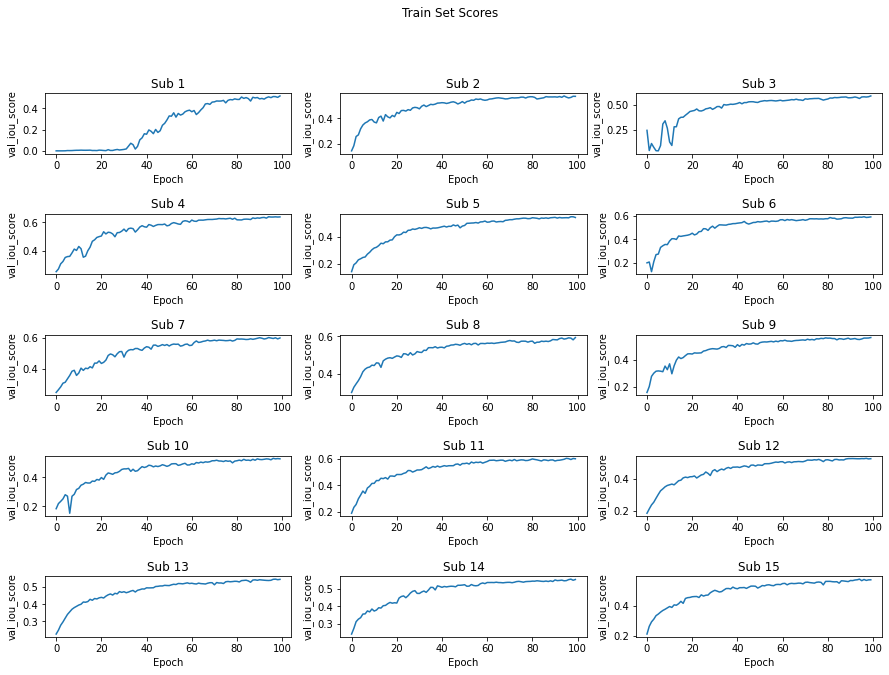

In [8]:
# plot the val_iou_scorelist
plt.subplots(5,3,constrained_layout = True,figsize = (15,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
plt.suptitle('Train Set Scores',y = 1)
for i in range(1,16):
  plotval_iou_score(i,val_iou_scorelist[i])

Note: From the figures above, we found the val_iou_core becomes generally high and converges to a specific value.

In [9]:
# test the model with the test data
t1prelist = [[]]
groundseglist = [[]]
t1list = [[]]
for test in testfile:
  groundseg = nib.load(os.path.join('/content/drive/My Drive/final example/',test)+'/tof_arteries.nii.gz').get_data()
  t1 = nib.load(os.path.join('/content/drive/My Drive/final example/',test)+'/t1_in_tof.nii.gz').get_data()
  groundseg = np.swapaxes(groundseg,0,2)
  t1 = np.swapaxes(t1,0,2)
  t1 = np.expand_dims(t1,axis=3)
  t1 = np.tile(t1,[1,1,1,3])
  t1list.append(t1)
  t1prelist.append(model.predict(t1))
  groundseglist.append(groundseg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  import sys


Note: We created three lists to store the test image sets.

In [10]:
# define a function to plot the comparison between groundseg and the predict t1
def plottestresult(i,t1,groundseg,t1_predict):
  plt.subplot(5,3,i*3+1)
  plt.imshow(t1[75,:,:,0])
  plt.title('Sub {} T1'.format(16+i))
  plt.subplot(5,3,i*3+2)
  plt.imshow(np.max(groundseg[:,:,:],axis = 0))
  plt.title('Sub {} Grounseg'.format(16+i))
  plt.subplot(5,3,i*3+3)
  plt.imshow(np.max(t1_predict[:,:,:,0],axis = 0))
  plt.title('Sub {} T1_predict'.format(16+i))

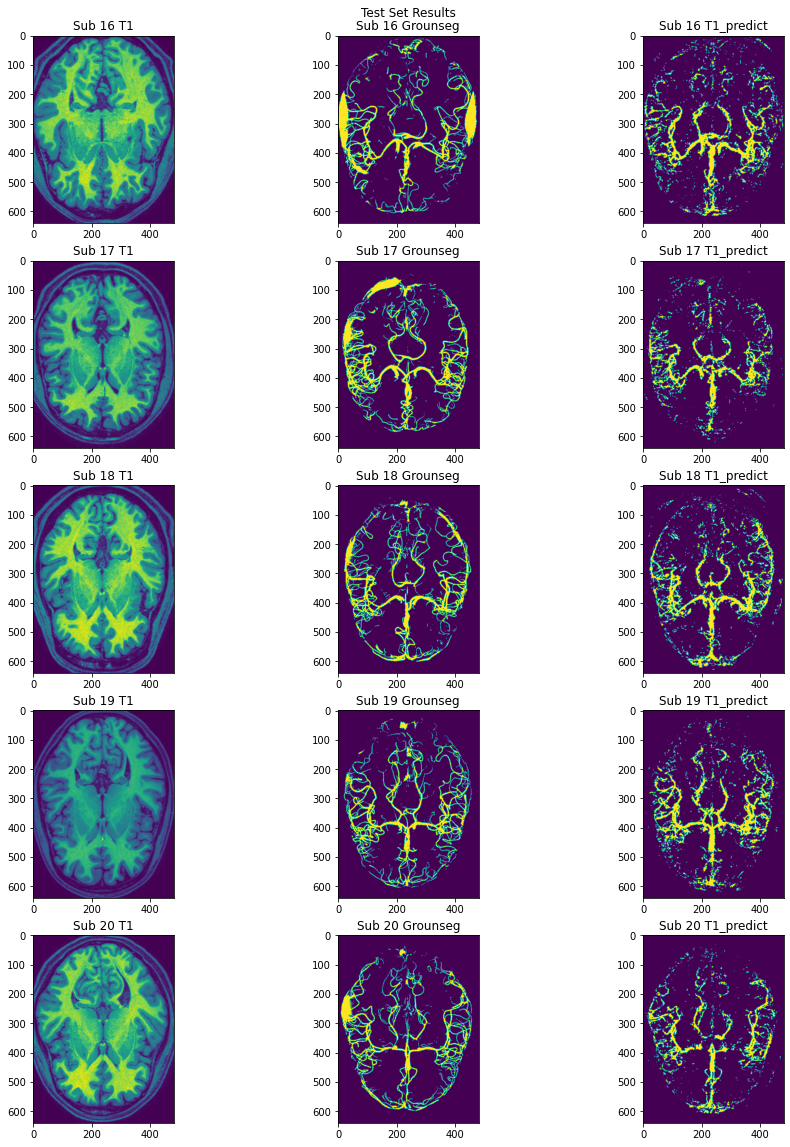

In [11]:
plt.subplots(5,3,figsize = (15,20))
plt.subplots_adjust(left=0.1, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.suptitle('Test Set Results',y = 0.9)
for i in range(0,5):
  plottestresult(i,t1list[i+1],groundseglist[i+1],t1prelist[i+1])

Note: From figures above, we noticed that,the groudseg extracted by Dr.Butler and the segmentation prediction were similar. As a tool for brain extraction, the Unet is indeed qualified. However, the segementation algorishm didn't show the arteries very continuously. The manually  goundseg was more vivid and specific.